In [1]:
import os
import pandas as pd
from pathlib import Path

path = Path('../../parsing_easylaw_ai/data')

In [2]:
cases = pd.read_csv(path / 'cases_base.csv', sep='\t', encoding='utf-8')

In [3]:
print(cases.shape[0])

109455


In [4]:
print(cases['search_term'].nunique())

2427


In [5]:
print(cases['Court'].nunique())

1434


In [6]:
# Judge column contains multiple judges!
print(cases['Judge'].str.lower().str.strip().nunique())

41283


<Axes: xlabel='Date'>

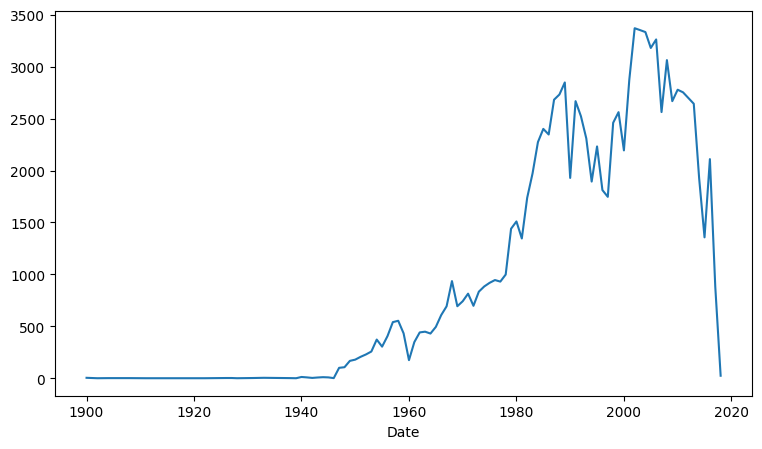

In [7]:
cases['Date'] = pd.to_datetime(cases['Date'])

cases['Date'].dt.year.value_counts().sort_index().plot(figsize=(9,5))

## check number of tokens

In [8]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"


enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [9]:
cases['Tokens_of_judgment'] = cases['Judgment'].apply(lambda x: len(enc.encode(x)))

<Axes: ylabel='Frequency'>

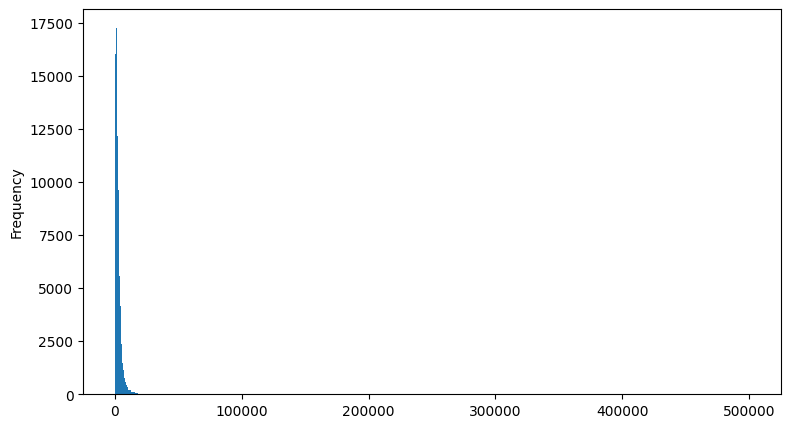

In [10]:
cases['Tokens_of_judgment'].plot.hist(bins=1000, figsize=(9,5))

<Axes: ylabel='Frequency'>

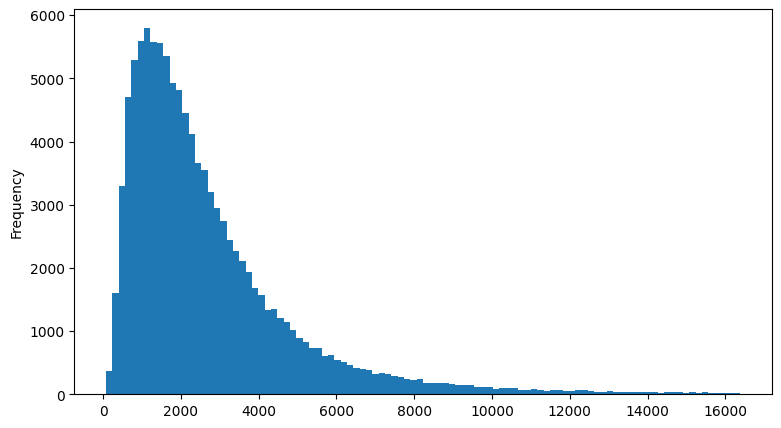

In [11]:
cases.loc[cases['Tokens_of_judgment'] < 2 ** 14, 'Tokens_of_judgment'].plot.hist(bins=100, figsize=(9,5))

In [12]:
# for Chat-GPT:
# Input:	$0.0015 / 1K tokens
# Output: 	$0.002 / 1K tokens

print(f"Average number of tokens per 1 case: {(cases['Tokens_of_judgment'].sum() / cases.shape[0])}")
print(f"Total cost of all cases: {((cases['Tokens_of_judgment'].sum() / cases.shape[0]) * 150000) * ((0.0015 + 0.002) / 2) / 1000}")

Average number of tokens per 1 case: 2952.545639760632
Total cost of all cases: 775.0432304371659


In [13]:
case = cases[(2500 < cases['Tokens_of_judgment']) & (cases['Tokens_of_judgment'] < 3000)].iloc[0]['Judgment']

print(case)


MALIK HAMID SAEED, J.- Accused-respondent Salim Khan son of Dr. Amir Dad was tried by Mr. Attaullah Khan, Sessions Judge, Bannu for the murder of Musharraf Khan by firing at him. The learned Sessions Judge on completion the trial arrived at the conclusion that prosecution failed to prove its case against the accused-respondent beyond any reasonable doubt and, therefore, acquitted him from the charge of murder.

The State has challenged the order of - acquittal recorded on 20-4-1993 through this appeal.

2. The case of the prosecution as per F.I.R. briefly runs as under:-

"On the fateful day i.e. 25-10-1997 complainant Payo Din alongwith his two nephews namely Shah Muhammad and Ghulam Nawaz went to Bazar for making purchases. They found Musharraf Khan (deceased) son of complainant sitting in the shop of one Sher Ali Baz in Tanchi Bazar and they also sat with him. Acquitted co-accused Hamidullah alias Titto and Salim Khan the present accused-respondent emerged on the scene armed with .

# NLTK

https://www.geeksforgeeks.org/python-text-summarizer/

the tool turned out to be ineffective

In [38]:
import re
import nltk
import heapq
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# nltk.download('punkt')
# nltk.download('stopwords')

In [ ]:
stopWords = set(stopwords.words("english"))
words = word_tokenize(case)

In [ ]:
sentence_list = nltk.sent_tokenize(case)

formatted_case = re.sub('[^a-zA-Z]', ' ', case)
formatted_case = re.sub(r'\s+', ' ', formatted_case)

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

word_frequencies = {}
for word in nltk.word_tokenize(formatted_case):
    if word not in stopwords:
        if word not in word_frequencies.keys():
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1

In [44]:
maximum_frequncy = max(word_frequencies.values())

for word in word_frequencies.keys():
    word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

In [45]:
sentence_scores = {}
for sent in sentence_list:
    for word in nltk.word_tokenize(sent.lower()):
        if word in word_frequencies.keys():
            if len(sent.split(' ')) < 30:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word]
                else:
                    sentence_scores[sent] += word_frequencies[word]

In [46]:
summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)

summary = ' '.join(summary_sentences)

In [47]:
print(summary)

(15) 3 grazed wounds 1/4" x 1/2" in size one inch apart and one inch to the left of wound No.3. (8) 2 fire-arm inlet wounds 1/4" x 1/4" each in size one on the left side and one on the bridge of the nose. (9) A fire-arm inlet wound 1/4" x 1/4" in size on the back of left side of scalp 1" to the left of occiput. (6) 2 fire-arm inlet wounds 1/4" x 1/4" each in size, 1" apart from one another in the second and third interspace 4" to the right of mid-sternal line. On internal examination the doctor found that nasal bone wounded,

frontal left perietal and occipital bones fractured, manages wounded, brain matter, vessels of brain all wounded badly. (2) 3 fire-arm outlet wounds 1/3" x 1/3" in size on posterior aspect of left forearm. (5) 2 fire-arm inlet wounds 1/4" x 1/4" each in size 1/2” apart and 1/2" below wound No.4.


# GENSIM

https://reintech.io/blog/create-text-summarization-tool-gensim

the tool turned out to be ineffective

# SPACY

https://www.activestate.com/blog/how-to-do-text-summarization-with-python/

the tool turned out to be ineffective

In [12]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest

# python -m spacy download en_core_web_sm

In [15]:
def summarize(text, per):
    nlp = spacy.load('en_core_web_sm')
    doc= nlp(text)
    tokens=[token.text for token in doc]
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in list(STOP_WORDS):
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=word_frequencies[word]/max_frequency
    sentence_tokens= [sent for sent in doc.sents]
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():                            
                    sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent]+=word_frequencies[word.text.lower()]
    select_length=int(len(sentence_tokens)*per)
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    final_summary=[word.text for word in summary]
    summary=''.join(final_summary)
    return summary

In [22]:
print(summarize(case, 0.02))

3. At the trial prosecution has examined P.W.l Doctor Mumtaz Khan who had conducted the post-mortem examination on the dead body of Musharraf Khan deceased at 4-30 p.m. on 25-10-1997 and found the following:-

External injuries j

(1) 3 fire-arm inlet wounds 1/4" x 1/4" in size on ventral aspect of left forearm 4" above the wrist joint.




# T5 (baseline)

https://thinkinfi.com/abstractive-text-summarization-in-12-lines-with-t5/

better than nothing, but still not so good

In [23]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [25]:
t5_name = 't5-small'        # t5-base
t5_model = T5ForConditionalGeneration.from_pretrained(t5_name)
t5_tokenizer = T5Tokenizer.from_pretrained(t5_name)

In [10]:
input_text = case.strip().replace("\n", "")

t5_ready_text = "summarize: "

In [11]:
device = torch.device('cpu')

In [21]:
tokenized_text = t5_tokenizer.encode(
    t5_ready_text, 
    return_tensors='pt', 
    max_length=512,
    padding='max_length', 
    truncation=True)\
        .to(device)

In [21]:
summary_tokens = t5_model.generate(
    tokenized_text,
    num_beams=4,
    no_repeat_ngram_size=2,
    length_penalty=2.0,
    min_length=30,
    max_length=70,
    early_stopping=True
    )

In [15]:
output = t5_tokenizer.decode(summary_tokens[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

print(len(output))
print(output.replace('. ', '.\n').capitalize())

259
Accused-respondent salim khan son of dr.
amir dad was tried by mr.
attaullah khan, sessions judge, bannu for the murder of musharraf khan by firing at him.
the learned sessions judge on completion the trial arrived at the conclusion that prosecution failed to


# Models from HuggingFace

In [10]:
from transformers import pipeline, AutoTokenizer
import re


tokenizer = AutoTokenizer.from_pretrained('marianna13/flan-t5-base-summarization')

# summarizer = pipeline("summarization", model='slauw87/bart_summarisation')
# summarizer = pipeline("summarization", do_sample=False)

In [11]:
# messages.append({"role": "user", "content": f"Produce python code using regular expressions that would turn 'Some some .some so.me .so.me so.me. .so.me. .some. some S.O.M.E. So.Me. Some. some. some.' into 'Some some .some so.me .so.me so.me. .so.me. .some.<eos> some S.O.M.E. .SOME SO.ME .SO.ME SO.ME. .SO.ME. .SOME. So.Me. Some.<eos> some.<eos> some.'"})

In [14]:
string_ = 'The State - so.me so.me. F.I.R. 8. i.e. Dr. Mr. Mrs. for P.Ws. Nos.3 Cr.P.C. Mress. Doctor. through this appeal. Also.'

# string_ = re.sub(r'\.([\S])', r'<<<>>> \1', string_)

re.sub(r'\B(?<! [A-Z]|Mr)([a-z])[.] ', r'\1.<eos>', string_)
# re.sub(r'\b(?![A-Za-z]*\.[A-Za-z]*\.)[A-Za-z]+\.(?![A-Za-z])', r'\g<0>', string_)

'The State - so.me so.me.<eos>F.I.R. 8. i.e. Dr. Mr. Mrs. for P.Ws.<eos>Nos.3 Cr.P.C. Mress.<eos>Doctor.<eos>through this appeal.<eos>Also.'

In [15]:
# why to chunkize: https://github.com/huggingface/transformers/issues/5204#issuecomment-1369389700


def text_to_list(text):
    text = text.replace('\n\n', '<eos>').replace('\n', '<eos>')
    # string_ = re.sub(r'\.([\S])', r'<<<>>> \1', string_)
    text = re.sub(r'\B(?<! [A-Z]|Mr|No|Ex)([a-z])[.] ', r'\1.<eos>', text)
    text = text.replace('Ws.<eos>', 'Ws. ')
    # string_ = string_.replace('<<<>>> ', '.')

    list_text = text.split('<eos>')
    list_text = list(map(lambda x: x.replace('\n', '    ').strip(), list_text))

    return list_text


def chunkize(sentences_list, chunk_size = 512):
    chunks = [sentences_list[0]]

    for sentence in sentences_list[1:]:
        if token_len(chunks[-1] + sentence) <= chunk_size:
            chunks[-1] += ' ' + sentence
        else:
            chunks.append(sentence)

    return chunks


def token_len(str_sequence):
    global tokenizer

    tokens = tokenizer.encode(
        str_sequence,
        return_tensors='pt', 
        max_length=2 ** 20,
        truncation=True)

    return len(tokens[0])


def recursion_summarizing(case, model, chunk_size, min_length, max_length):
    if token_len(case) < chunk_size:
        return ''

    case_list = text_to_list(case)
    chunks = chunkize(case_list, chunk_size)

    force_summarization = False
    # for chunk in chunks:
    #     if token_len(chunk) < max_length:
    #         force_summarization = True


    output = model(chunks, min_length=min_length, max_length=max_length, early_stopping=True)

    output = [i['summary_text'] for i in output]
    output = ' '.join(output)
    output = output.strip().replace(' .', '.')

    string_output = '\n'.join(text_to_list(output))

    if token_len(output) > (chunk_size * 2) or force_summarization:
        string_output = recursion_summarizing(output, model, chunk_size, min_length, max_length)

    return string_output

In [67]:
model_ids = [
    'sshleifer/distilbart-cnn-12-6',                # bad with punctuation
    # 'marianna13/flan-t5-base-summarization',        # generally good, but breaks off at the end
    'Falconsai/text_summarization',                 # not bad, lack of punctuation
    'slauw87/bart_summarisation'                    # a lot of misinterpreting, but well structured and concise
]

In [62]:
outputs = {}
for model_id in model_ids:
    summarizer = pipeline("summarization", model=model_id)

    outputs[model_id] = recursion_summarizing(case=case, model=summarizer, chunk_size=512-10, min_length=30, max_length=150)

    print(f"\n\n\nModel {model_id} ({token_len(outputs[model_id])} token length):\n\n {outputs[model_id]}\n")
    
    del summarizer

[473, 495, 486, 444, 484, 484]



Model sshleifer/distilbart-cnn-12-6 (437 token length):

 Salim Khan son of Dr. Amir Dad was tried by Mr Attaullah Khan, Sessions Judge, Bannu for the murder of Musharraf Khan by firing at him.
The learned Sessions Judge on completion the trial arrived at the conclusion that prosecution failed to prove its case against the accused-respondent beyond any reasonable doubt and, therefore, acquitted him from the charge of murder.
A graze wound 1/4" x 1/2" in size on the right side of upper lip corresponds to wounds Nos.4, 5 and 6, pellets palpable under the skin.
A group of.12 fire-arm inlet wounds on the front of left side of chest 3” below the left nipple in an area about 4" in circumstance.
P.W.2 Shahabuddin who was, A.-S.I., Police Station, Bannu City has registered the case on the report of complainant Payo Din.
On internal examination the doctor found that nasal bone wounded,frontal left perietal and occipital bones fractured, brain matter, vessels of

# Models from HuggingFace using API

In [ ]:
import requests

API_URL = f"https://api-inference.huggingface.co/models/{model_id}"
headers = {"Authorization": f"Bearer {os.getenv('HF_API_TOKEN')}"}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

In [ ]:
output = query({
	"inputs": case,
})

In [76]:
print(output[0]['summary_text'].replace(' . ', '.\n'))

 Salim Khan son of Dr. Amir Dad was tried by Mr Attaullah Khan, Sessions Judge, Bannu for the murder of Musharraf Khan by firing at him.
The State has challenged the order of - acquittal recorded on 20-4-1993 through this appeal .


### May be tried: https://github.com/amoramine/Pegasus_with_Longformer_summarization

# CHATGPT

best solution, but it's a paid service :(

In [281]:
import openai


openai.api_key = os.getenv('CHATGPTKEY')

In [282]:
messages = [{"role": "system", "content": "You are an intelligent assistant."}]

In [73]:
messages.append({"role": "user", "content": f"Summarize this: {case}"})
chat = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=messages)

In [77]:
print(chat.choices[0].message.content.replace('. ', '.\n'))

Salim Khan, the accused-respondent, was acquitted by the Sessions Judge in Bannu for the murder of Musharraf Khan.
The judge concluded that the prosecution failed to prove the case against Salim Khan beyond a reasonable doubt.
The state has challenged the acquittal through this appeal.
The prosecution's case was that Salim Khan, along with another accused, shot and killed Musharraf Khan.
The post-mortem examination showed multiple gunshot wounds to the deceased's body.
The eyewitnesses to the occurrence were closely related to the deceased, raising doubts about their testimony.
No independent witnesses were produced at the trial.
The presence of the witnesses at the scene was questioned, as no one else in the busy market witnessed the incident.
Salim Khan had earlier filed a complaint against the other accused, indicating a conflict between them.
Considering these factors, the court concluded that the acquittal of Salim Khan was justified and dismissed the appeal.


In [78]:
messages.append({"role": "user", "content": f"Summarize even more concisely"})
chat = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=messages)

In [81]:
print(chat.choices[0].message.content.replace('. ', '.\n'))

The accused, Salim Khan, was tried for the murder of Musharraf Khan.
The court found that the prosecution failed to prove the case beyond a reasonable doubt and acquitted the accused.
The state has challenged this acquittal but the court upheld it, stating that there was insufficient evidence and no reason to overturn the acquittal.
The appeal was dismissed.
